In [77]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime
import os
import requests
import zipfile 

In [78]:
filename = 'open_data_year_one.zip'
url = 'https://s3.amazonaws.com/pronto-data/open_data_year_one.zip'
csv_filename = "2015_trip_data.csv"

if os.path.exists(filename):
  print("File exists, skipping download")
else: 
    req = requests.get(url)
    assert req.status_code == 200 # if the download failed, this line will generate an error
    with open(filename, 'wb') as f:
      f.write(req.content)
zf = zipfile.ZipFile(filename)
df = pd.read_csv(zf.open(csv_filename))

File exists, skipping download


In [84]:
def funcdate(row):
    return row['starttime'].split()[0]
def funcdayofweek(row):
    month, day, year = (int(x) for x in row['Date'].split('/'))  
    date_full = datetime.date(year, month, day)
    return date_full.strftime("%A")  



df['Date'] = df.apply(funcdate, axis=1)
df['DayOfWeek'] = df.apply(funcdayofweek, axis=1)



In [85]:
df.head(3)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,Date,DayOfWeek
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960.0,10/13/2014,Monday
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970.0,10/13/2014,Monday
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988.0,10/13/2014,Monday


In [86]:
from_counts_byDayOfWeek = df.groupby(['DayOfWeek', 'from_station_id']).size()

In [87]:
to_counts_byDayOfWeek = df.groupby(['DayOfWeek', 'to_station_id']).size()

In [153]:
days = df.groupby(['DayOfWeek']).from_station_id.nunique()
days

DayOfWeek
Friday       54
Monday       54
Saturday     54
Sunday       54
Thursday     54
Tuesday      55
Wednesday    54
Name: from_station_id, dtype: int64

In [152]:
from_df = from_counts_byDayOfWeek.reset_index()

In [91]:
to_df = to_counts_byDayOfWeek.reset_index()

In [92]:
from_df.columns = ['DayOfWeek', 'from_station_id', 'from_bikes_count']

In [93]:
to_df.columns = ['DayOfWeek', 'to_station_id', 'to_bikes_count']

In [120]:
bikes_count_df = pd.merge(from_df, to_df, left_on=['from_station_id', 'DayOfWeek'], right_on=['to_station_id', 'DayOfWeek'], how='outer')

In [121]:
bikes_count_df['from_bikes_count'].fillna(0, inplace=True)

In [122]:
bikes_count_df['to_bikes_count'].fillna(0, inplace=True)

In [123]:
bikes_count_df['from_station_id'] = np.where(bikes_count_df['from_station_id'].isnull(), bikes_count_df['to_station_id'], bikes_count_df['from_station_id'])

In [124]:
bikes_count_df['to_station_id'] = np.where(bikes_count_df['to_station_id'].isnull(), bikes_count_df['from_station_id'], bikes_count_df['to_station_id'])

In [127]:
bikes_count_df['difference'] = bikes_count_df.from_bikes_count - bikes_count_df.to_bikes_count

In [135]:
bikes_count_df['average_count'] = bikes_count_df.difference/54

In [132]:
bikes_count_df.head()

,DayOfWeek,from_station_id,from_bikes_count,to_station_id,to_bikes_count,difference,average_count
0,Friday,BT-01,921.0,BT-01,850,71.0,1.314815
1,Friday,BT-03,657.0,BT-03,470,187.0,3.462963
2,Friday,BT-04,343.0,BT-04,280,63.0,1.166667
3,Friday,BT-05,516.0,BT-05,502,14.0,0.259259
4,Friday,CBD-03,465.0,CBD-03,639,-174.0,-3.222222


In [133]:
days_df = bikes_count_df.pivot(index='from_station_id', columns='DayOfWeek', values='difference')
days_df.fillna(0, inplace=True)
d = days_df/days
d.head()

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
from_station_id,,,,,,,
BT-01,1.314815,0.333333,0.000000,-0.870370,0.166667,0.945455,-0.333333
BT-03,3.462963,0.814815,3.092593,1.518519,2.907407,1.436364,1.796296
BT-04,1.166667,1.092593,0.351852,0.703704,1.555556,1.072727,0.796296
BT-05,0.259259,-0.203704,-0.018519,-0.092593,-1.018519,-0.127273,-0.481481
CBD-03,-3.222222,-2.814815,-2.537037,-1.277778,-2.407407,-2.636364,-3.296296


In [146]:
def plot_bar1(df, column, opts):
    n_groups = len(df.index)
    index = np.arange(n_groups)
    rects1 = plt.bar(index, df[column])
    if opts.has_key('xlabel'):
      plt.xlabel(opts['xlabel'])
    else:
        pass
    if opts.has_key('ylabel'):
      plt.ylabel(opts['ylabel'])
    else:
        pass
    if opts.has_key('xticks') and opts['xticks']:
      plt.xticks(index, df.index)  
      _, labels = plt.xticks() 
      plt.setp(labels, rotation=90)
    else:
      labels = ['' for x in df.index]
      plt.xticks(index, labels)   
    if opts.has_key('ylim'):
      plt.ylim(opts['ylim'])
    else:
        pass
    plt.title(column)

In [147]:
def plot_barN(df, columns, opts):
    """
    Does a bar plot for a single column.
    :param pd.DataFrame df:
    :param list-of-str columns: names of the column to plot
    :param dict opts: key is plot attribute
    """
    num_columns = len(columns)
    local_opts = dict(opts)
    idx = 0
    for column in columns:
        idx += 1
        local_opts['xticks'] = False
        local_opts['xlabel'] = ''
        if idx == num_columns:
          local_opts['xticks'] = True
          local_opts['xlabel'] = opts['xlabel']
        plt.subplot(num_columns, 1, idx)
        plot_bar1(df, column, local_opts)

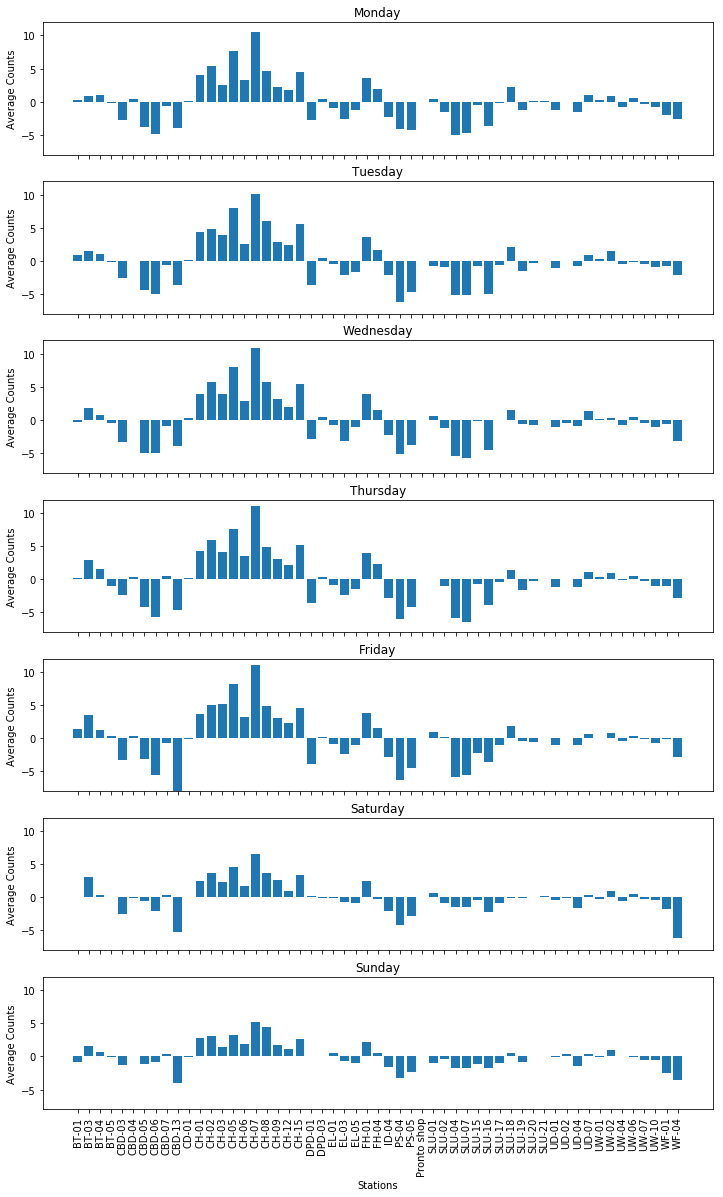

In [148]:
fig = plt.figure(figsize=(12, 20))
opts = {'xlabel': 'Stations', 'ylabel': 'Average Counts', 'ylim' : (-8,12)}
plot_barN(d, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], opts)

In [149]:
def plot_bar1(df, column, opts):
    n_groups = len(df.index)
    index = np.arange(n_groups)
    rects1 = plt.bar(index, df[column])
    if opts.has_key('xlabel'):
      plt.xlabel(opts['xlabel'])
    else:
        pass
    if opts.has_key('ylabel'):
      plt.ylabel(opts['ylabel'])
    else:
        pass
    if opts.has_key('xticks') and opts['xticks']:
      plt.xticks(index, df.index)  
      _, labels = plt.xticks() 
      plt.setp(labels, rotation=90)
    else:
      labels = ['' for x in df.index]
      plt.xticks(index, labels)   
    if opts.has_key('ylim'):
      plt.ylim(opts['ylim'])
    else:
        pass
    plt.title(column)

In [150]:
def plot_barN(df, columns, opts):
    """
    Does a bar plot for a single column.
    :param pd.DataFrame df:
    :param list-of-str columns: names of the column to plot
    :param dict opts: key is plot attribute
    """
    num_columns = len(columns)
    local_opts = dict(opts)
    idx = 0
    for column in columns:
        idx += 1
        local_opts['xticks'] = False
        local_opts['xlabel'] = ''
        local_opts['yticks'] = False
        local_opts['ylabel'] = ''
        if idx == num_columns:
          local_opts['xticks'] = True
          local_opts['xlabel'] = opts['xlabel']
        if idx % 2 != 0:
          local_opts['yticks'] = True
          local_opts['ylabel'] = opts['ylabel']
        plt.subplot(num_columns, 2, idx)
        plot_bar1(df, column, local_opts)

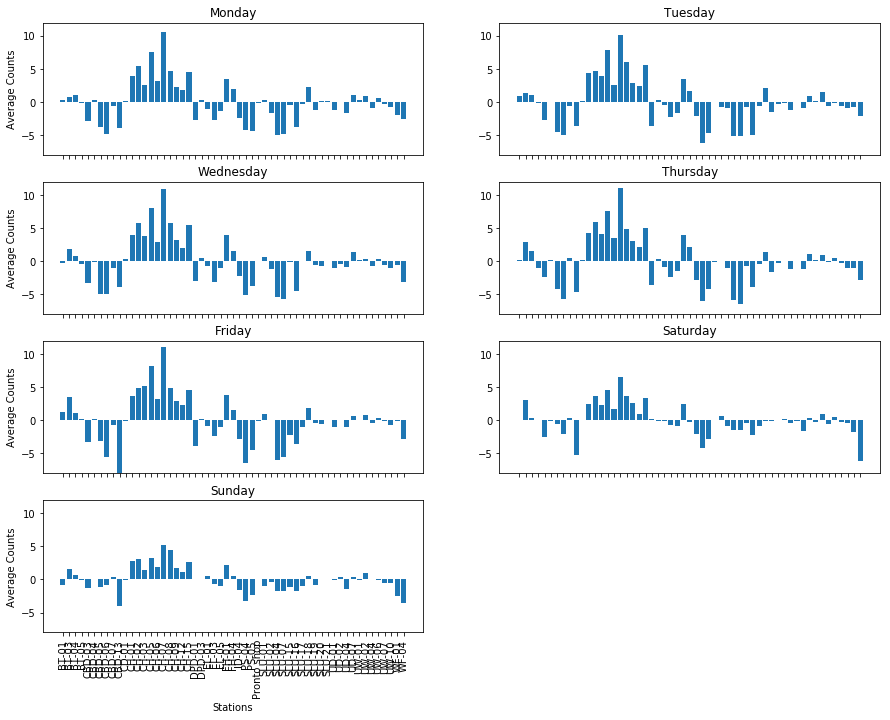

In [151]:
fig = plt.figure(figsize=(15, 20))  # Controls global properties of the bar plot
opts = {'xlabel': 'Stations', 'ylabel': 'Average Counts', 'ylim' : (-8,12)}
plot_barN(d, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], opts)